In [45]:
import torch
import numpy as np
import random
import zarr
from skimage.segmentation import relabel_sequential
from scipy.ndimage import distance_transform_edt, map_coordinates
from local import train, plot_two, plot_three, plot_four

ModuleNotFoundError: No module named 'local'

In [2]:
random.seed(26)
zarr_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/zarr_storage/test.zarr"
root = zarr.open (zarr_path)
test_cond = random.choice (list(root.keys()))
test_image = random.choice (list (root[test_cond].keys()))
test_array = np.array (root[test_cond][test_image]["y"], dtype = "int")
print (test_array.shape)
type (test_array)



(11, 2728, 3639)


numpy.ndarray

In [3]:
for i in range(test_array.shape[0]):
    print (test_array[i, :, :].max())

34
61
0
0
27
0
0
37
0
0
1262


In [4]:
collapsed_array = test_array.sum(axis = 0)
print (collapsed_array.shape)
print (collapsed_array.max())

(2728, 3639)
1262


In [5]:
start_index = 1
test_relab = test_array.copy()
print (test_relab.shape)
# for i in range(test_relab.shape[0]):
#     print (test_relab[i, :, :].max())
for i in range (test_relab.shape[0]):
    if test_relab [i, :, :].max() > 0:
        test_relab [i, :, :] = relabel_sequential (test_relab [i, :, :], offset = start_index)[0]
        start_index = test_relab [i, :, :].max()
    else:
        test_relab [i, :, :] = test_relab [i, :, :]

# relabelled_array = relabel_sequential(collapsed_array)[0]
# print (relabelled_array.max())
# 2729 //512
print (test_relab.shape)

(11, 2728, 3639)
(11, 2728, 3639)


In [62]:
relabel_sequential?

Signature: relabel_sequential(label_field, offset=1)
Docstring:
Relabel arbitrary labels to {`offset`, ... `offset` + number_of_labels}.

This function also returns the forward map (mapping the original labels to
the reduced labels) and the inverse map (mapping the reduced labels back
to the original ones).

Parameters
----------
label_field : numpy array of int, arbitrary shape
    An array of labels, which must be non-negative integers.
offset : int, optional
    The return labels will start at `offset`, which should be
    strictly positive.

Returns
-------
relabeled : numpy array of int, same shape as `label_field`
    The input label field with labels mapped to
    {offset, ..., number_of_labels + offset - 1}.
    The data type will be the same as `label_field`, except when
    offset + number_of_labels causes overflow of the current data type.
forward_map : ArrayMap
    The map from the original label space to the returned label
    space. Can be used to re-apply the same mappin

In [7]:
def crop_tiles (image, crop_size):
    h_tiles = (image.shape[0]//crop_size) + 1
    v_tiles = (image.shape[1]//crop_size) + 1

    new_h_shape = crop_size * h_tiles
    new_v_shape = crop_size * v_tiles

    new_image = np.zeros (shape = (new_h_shape, new_v_shape)) 
    new_image[0:image.shape[0], 0:image.shape[1]] = image
    tiles = []
    for i in range (h_tiles):
        for j in range (v_tiles):
            y_start = i * crop_size
            y_end = (i+1) * crop_size
            x_start = j * crop_size
            x_end = (j+1)* crop_size

            tile = new_image [y_start:y_end , x_start:x_end]
            tiles.append (tile)
    



    return (np.stack (tiles))

crop = crop_tiles (collapsed_array, 512)
print (crop.shape)
print (collapsed_array.shape)





(48, 512, 512)
(2728, 3639)


In [8]:
def crop_tiles_2(image, crop_size):
    h, w = image.shape
    h_tiles = (h + crop_size - 1) // crop_size  # ceil division
    v_tiles = (w + crop_size - 1) // crop_size

    # Pad only if needed
    pad_h = h_tiles * crop_size - h
    pad_w = v_tiles * crop_size - w
    if pad_h > 0 or pad_w > 0:
        image = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')

    # Preallocate output array
    tiles = np.empty((h_tiles * v_tiles, crop_size, crop_size), dtype=image.dtype)

    idx = 0
    for i in range(h_tiles):
        for j in range(v_tiles):
            y_start = i * crop_size
            x_start = j * crop_size
            tiles[idx] = image[y_start:y_start + crop_size, x_start:x_start + crop_size]
            idx += 1

    return tiles

crop_2 = crop_tiles_2 (collapsed_array, 512)
print (crop_2.shape)
print (collapsed_array.shape)

(48, 512, 512)
(2728, 3639)


In [ ]:
# def load_data(zarr_path, crop_size):
#     root = zarr.open(zarr_path, mode='r')

#     # list of diseases
#     diseases = root.keys()
#     x_list = []
#     y_list = []
#     for d in diseases:
#         for fov in root[d].keys():
#             x = root[d][fov]['x'][:]
#             y = root[d][fov]['y'][:].astype ("int64")

#             # Preprocessing
#             start_index = 1
#             for i in range (y.shape[0]):
#                 if y [i, :, :].max() > 0:
#                     y [i, :, :] = relabel_sequential (y [i, :, :], offset = start_index)[0]
#                     start_index = y [i, :, :].max()
#                 else:
#                     y [i, :, :] = y [i, :, :]
#             # collapse masks
#             y_collapsed = y.sum(axis = 0)
            
#             # tile x and y
#             x_processed = crop_tiles_2 (x, crop_size)
#             y_processed = crop_tiles_2 (y_collapsed, crop_size)

#             x_list.append(x_processed)
#             y_list.append(y_processed)

#     x = np.concatenate(x_list, axis = 0)
#     y = np.concatenate(y_list, axis = 0)
#     return x, y 

In [ ]:
# load = load_data (zarr_path, crop_size = 512)

: 

In [5]:
print (np.zeros (shape = (512, 512)))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
def load_data (zarr_path):
    x_arrays = []
    y_arrays = []
    root = zarr.open (zarr_path)
    for conditions in list (root.keys()):
        images = root [conditions].keys()
        for fov in images:
            x = root[conditions][fov]["x_cropped"][:]
            y = root[conditions][fov]["y_cropped"][:].astype ("int16")
            #y1 = root[conditions][fov]["y_cropped"][:].astype ("int64")
            #assert (y == y1).all()
            # print (x.dtype, y.dtype)
            x_arrays.append (x)
            y_arrays.append (y)
    x_array = np.concatenate (x_arrays)
    y_array = np.concatenate (y_arrays)
    return x_array, y_array
load = load_data (zarr_path)



In [31]:
print (load[0].shape)
print (load[1].shape)
print (len (load[0]))
print (load[0][0].shape)


(4316, 512, 512)
(4316, 512, 512)
4316
(512, 512)


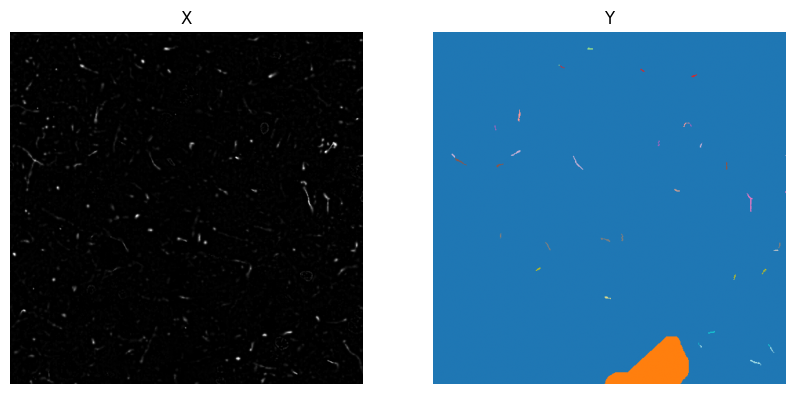

In [29]:
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

index = random.choice (range (0, load[0].shape[0]))
x = load[0][index, :, :]
y = load [1][index, :, :]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(x, cmap="gray")
axes[0].set_title(f"X")
axes[0].axis("off")
    
axes[1].imshow(y, cmap="tab20")
axes[1].set_title(f"Y")
axes[1].axis("off")
    
plt.show()

In [40]:
def compute_sdt(labels: np.ndarray, scale: int = 5):
    """Function to compute a signed distance transform."""
    dims = len(labels.shape)
    # Create a placeholder array of infinite distances
    distances = np.ones(labels.shape, dtype=np.float32) * np.inf
    for axis in range(dims):
        # Here we compute the boundaries by shifting the labels and comparing to the original labels
        # This can be visualized in 1D as:
        # a a a b b c c c
        #   a a a b b c c c
        #   1 1 0 1 0 1 1
        # Applying a half pixel shift makes the result more obvious:
        # a a a b b c c c
        #  1 1 0 1 0 1 1
        bounds = (
            labels[*[slice(None) if a != axis else slice(1, None) for a in range(dims)]]
            == labels[
                *[slice(None) if a != axis else slice(None, -1) for a in range(dims)]
            ]
        )
        # pad to account for the lost pixel
        bounds = np.pad(
            bounds,
            [(1, 1) if a == axis else (0, 0) for a in range(dims)],
            mode="constant",
            constant_values=1,
        )
        # compute distances on the boundary mask
        axis_distances = distance_transform_edt(bounds)

        # compute the coordinates of each original pixel relative to the boundary mask and distance transform.
        # Its just a half pixel shift in the axis we computed boundaries for.
        coordinates = np.meshgrid(
            *[
                (
                    range(axis_distances.shape[a])
                    if a != axis
                    else np.linspace(
                        0.5, axis_distances.shape[a] - 1.5, labels.shape[a]
                    )
                )
                for a in range(dims)
            ],
            indexing="ij",
        )
        coordinates = np.stack(coordinates)

        # Interpolate the distances to the original pixel coordinates
        sampled = map_coordinates(
            axis_distances,
            coordinates=coordinates,
            order=3,
        )

        # Update the distances with the minimum distance to a boundary in this axis
        distances = np.minimum(distances, sampled)

    # Normalize the distances to be between -1 and 1
    distances = np.tanh(distances / scale)

    # Invert the distances for pixels in the background
    distances[labels == 0] *= -1
    return distances

In [41]:
import os
from torchvision.io import decode_image 
from torch.utils.data import Dataset

class CenterCropDataset(Dataset):
    def __init__(self, zarr_path):
        
        
        self.zarr_path = zarr_path

        self.x, self.y = load_data(self.zarr_path)
        
       

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = self.x[idx]  
        seg = self.y[idx] 
        sdt = compute_sdt (seg) 

    

        return torch.tensor(img, dtype=torch.float32), torch.tensor(sdt, dtype=torch.float32)

In [42]:
dataset = CenterCropDataset (zarr_path=zarr_path)


In [44]:
print (type(dataset))
img, sdt = dataset[10]  # get the image and the distance transform
# We use the <code style="color: black">plot_two</code> function (imported in the first cell) to verify that our
# dataset solution is correct. The output should show 2 images: the raw image and
# the corresponding SDT.
plot_two(img, sdt[0], label="SDT")

<class '__main__.CenterCropDataset'>


NameError: name 'distance_transform_edt' is not defined